In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置



rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
rcParams['font.sans-serif']=['SimHei'] #显示中文标签

In [2]:
def read_xlsx(startdate,enddate):
    #读取数据
    index_matrix = pd.read_excel('基本指数历史价格数据.xlsx', sheet_name='Sheet1',index_col=0)
    #指定回测区间
    index_matrix = index_matrix.loc[(index_matrix.index>startdate) & (index_matrix.index<=enddate)]
    
    #消费风格指数
    consume_index=index_matrix.iloc[:,0]
    #成长风格指数
    growth_index=index_matrix.iloc[:,1]
    #周期风格指数
    cycle_index=index_matrix.iloc[:,2]
    #金融风格指数
    finance_index=index_matrix.iloc[:,3]
    #中证800
    ashare_index=index_matrix.iloc[:,4]
    #标普500
    standard_index=index_matrix.iloc[:,5]
    #组合指数矩阵（思路一）
    collections_one = pd.DataFrame((ashare_index,standard_index)).T
    collections_one_plus = pd.DataFrame((consume_index,growth_index,cycle_index,finance_index)).T
    #组合指数矩阵（思路二）
    collections_two = pd.DataFrame((consume_index,growth_index,cycle_index,finance_index,standard_index)).T
    
    return collections_one,collections_one_plus,collections_two,consume_index,growth_index,cycle_index,finance_index,ashare_index,standard_index

In [3]:
def cov_output(certain_index):
    
    #计算协方差矩阵
    cov_matrix=np.cov(certain_index,rowvar=False)
    
    return cov_matrix

In [4]:
def ret_output(certain_index):
    
    #计算收益率矩阵
    daily_index_ret = certain_index.pct_change()
    #用0填补缺失值NA，如有
    daily_index_ret.fillna(0, inplace=True)
    
    #计算累积日收益率,基准日以净值1计算
    cum_daily_ret = (1 + daily_index_ret).cumprod()
    #计算年化收益率,基准日以净值1计算,每年按照244个交易日计算（月度的话改为12，季度的话改为4）
    cum_yearly_ret = (1 + daily_index_ret).cumprod()[-1]**(244/len(cum_daily_ret))-1
    
    return daily_index_ret,cum_daily_ret,cum_yearly_ret

In [5]:
#设置回测周期
#Y代表年度调仓，Q代表季度调仓，M代表月度调仓
def cycle_reset(certain_index,period):
    new_period_index = certain_index.resample(period , closed='right' , label='right').mean()
    return new_period_index

In [6]:
#正态分布拟合
def normfun(x,mu,sigma):
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf

In [7]:
#年化波动率
def vol_output(certain_index):
    close =np.array(certain_index)
    ln_close = np.log(close)
    #使用对数指数的差值，即收益率
    r = [ln_close[i+1]-ln_close[i] for i in range(0,len(ln_close)-1)]
    r= np.array(r)

    mean = r.mean()
    #波动率
    std = r.std()
    #年波动率,假设244个交易日
    year_std = std*244**(1/2)
    x_max = r.max()
    x_min = r.min()

    x = np.arange(x_min, x_max, 0.001)
    y = normfun(x, mean, std)

    plt.xlim(x_min, x_max)
    plt.hist(r, bins=int(np.sqrt(len(r))), rwidth=0.9, density=True)
    plt.plot(x, y)
    plt.show()
    
    return year_std

In [8]:
#夏普比率计算
def sharpe_output(certain_index):
    daily_index_ret,cum_daily_ret,cum_yearly_ret = ret_output(certain_index)
    # 以国债为参考，假设年化收益率为2.25%，每年244个交易日
    excess_daily_ret = daily_index_ret - 0.0225/244
    # 计算年化夏普比率，默认为244个交易日。
    sharpe = np.sqrt(244) * excess_daily_ret.mean() / excess_daily_ret.std()
    
    return sharpe

In [9]:
#最大回撤
def max_drawdown(X):
    max_draw = 0
    peak = X[0]
    for x in X:
        if x > peak: 
            peak = x
        drawback = (peak - x) / peak
        if drawback > max_draw:
            max_draw = drawback
            
    return max_draw

In [10]:
# Calmar Ratio
def calmar_output(certain_index):
    daily_index_ret,cum_daily_ret,cum_yearly_ret = ret_output(certain_index)
    mdd = max_drawdown(cum_daily_ret)
    calmar = cum_yearly_ret/mdd
    
    return calmar

In [11]:
class Strategy():
    #风险平价策略即通过调平一个投资组合中各项资产对整个组合的边际风险贡献来实现组合的风险调整后收益最大化
    #本例中我们使用A股与美股部分指数历史价格数据按要求构建一个使用风险平价策略的投资组合，并对组合进行回测。
    
    #组合风险计算
    def calculate_portfolio_var(w,V):
        w = np.matrix(w)
        return (w*V*w.T)[0,0]
    
    #计算单个资产对总体的风险贡献度
    def calculate_risk_contribution(w,V):
        w = np.matrix(w)
        sigma = np.sqrt(Strategy.calculate_portfolio_var(w,V))
        MRC = V*w.T
        RC = np.multiply(MRC,w.T)/sigma
        return RC
    
    def risk_budget_objective(x,pars):
        V = pars[0]
        x_t = pars[1]
        sig_p = np.sqrt(Strategy.calculate_portfolio_var(x,V))
        risk_target = np.asmatrix(np.multiply(sig_p,x_t))
        asset_RC = Strategy.calculate_risk_contribution(x,V)
        J = sum(np.square(asset_RC-risk_target.T))[0,0]
        return J
    
    #约束条件：权重之和为1
    def total_weight_constraint(x):
        return np.sum(x)-1.0
    
    def long_only_constraint(x):
        return x
    
    def calcu_w(x,V):
        w0 = [1,1,1,1,1]
        
        x_t = x
        cons = ({'type':'eq','fun':Strategy.total_weight_constraint},
                {'type':'ineq','fun':Strategy.long_only_constraint})
        res = minimize(Strategy.risk_budget_objective,w0,args=[V,x_t],method='SLSQP',constraints=cons,options={'disp':True})
        w_rb = np.asmatrix(res.x)
        return w_rb

    def plot_rc(w,V):
        rc = Strategy.calculate_risk_contribution(w,V)
        rc = rc.tolist()
        rc = [i[0] for i in rc]
        rc = pd.DataFrame(rc,columns=['risk contribution'],index=[1,2,3,4,5])
        plt.plot(rc)

In [70]:
def strategy_cycle_change(startdate,enddate,period):
    index_one,index_one_plus,index_two,a,b,c,d,e,f = read_xlsx(startdate,enddate)
    
    #思路二  
    index_two = cycle_reset(index_two,period)
#     print('您选择的指数按照年份/季度/月度合并数据：',index_two)
    a = cycle_reset(a,period)
    b = cycle_reset(b,period)
    c = cycle_reset(c,period)
    d = cycle_reset(d,period)
    e = cycle_reset(e,period)
    f = cycle_reset(f,period)   
    
    #————————策略部分————————#
    #收益率矩阵搭建
    ah,ai,aj = ret_output(a)
    bh,bi,bj = ret_output(b)
    ch,ci,cj = ret_output(c)
    dh,di,dj = ret_output(d)
    eh,ei,ej = ret_output(e)
    fh,fi,fj = ret_output(f)
#     print('ah的值是:',ah.shape)
    daily_ret = np.vstack((ah,bh,ch,dh,fh)).T
    daily_cum_ret = np.vstack((ai,bi,ci,di,fi)).T
    yearly_cum_ret = np.vstack((aj,bj,cj,dj,fj)).T
#     print('您选取的指数每日收益率为：',daily_ret)
#     print('您选取的指数累积日收益率为：',daily_cum_ret)
#     print('您选取的指数累积年收益率为：',yearly_cum_ret)

    #添加时间索引
    pd.DataFrame(daily_ret,index = index_two.index)
#     print('daily_ret的值是:',daily_ret,daily_ret.shape)
    

    Vector = 100000
    
    strategy_ret_collection=[]
    original_ret_collection=[]
    weight_collection=[]
    
    for m in range(2,len(index_two)):
        temp_index = index_two.iloc[m-2:m]
        
        g = cov_output(temp_index)
#         print('您选取的指数协方差为：',g)

        for j in range(0,len(g)):
            #赋予各资产初始配置权重
            w_rb = Strategy.calcu_w(g[j],Vector)
#             print('w_rb的值是：',w_rb,w_rb.shape,g[0].size)

        w_sum = 0
        weight = 0
        for i in range(0,w_rb.size):
            w_sum = w_sum +w_rb[0,i]
#             print('w_sum的数值是：',w_sum)

        weight=w_rb/w_sum  
        weight_collection = np.append(weight_collection,weight)
        #权重为负数视为卖空
#         print('各资产权重：',weight,weight.shape,g[0].size) 
            
#         print('daily_ret[1]的值是:',daily_ret[1],daily_ret[1].shape)
        for k in range(0,len(daily_ret)):
            #降维，求和
            strategy_ret = np.dot(daily_ret[k],weight.T)
            strategy_ret_collection = np.append(strategy_ret_collection,strategy_ret)

            original_ret = np.dot(daily_ret[k],np.array([2,2,2,2,2]).T)
            original_ret_collection = np.append(original_ret_collection,original_ret)
#     print('策略回测收益率累加的值是:',strategy_ret_collection.shape,strategy_ret_collection)
#     print('初始指数收益率累加的值是:',original_ret_collection.shape,original_ret_collection)

    print('各资产权重变化表：',weight_collection,weight_collection.shape) 
    strategy_net_value = np.cumsum(strategy_ret_collection)
#     print(strategy_net_value)
    original_net_value = np.cumsum(original_ret_collection)
#     print(original_net_value)
    
    
    # 策略回测净值走势
#     m = strategy_ret_collection
#     print(m)
#     plt.imshow(m, interpolation='nearest', cmap=plt.cm.ocean)
#     plt.colorbar()
#     plt.show()
    

In [21]:
def main():
    
    #index_one,index_one_plus,index_two是三个指数组合，其中
        #index_one是中证800指数以及标普500指数
        #index_one_plus是4条细分风格指数
        #index_two是4条细分风格指数以及标普500指数
    index_one,index_one_plus,index_two,a,b,c,d,e,f = read_xlsx(startdate,enddate)
    
    k = cycle_reset(index_two,period)
    print('您选择的指数按照年份/季度/月度合并数据：',k)
    
    #思路二  
    
    g = cov_output(index_two)
    print('您选取的指数协方差为：',g)    
    l = vol_output(index_two)
    print('您选取的指数年化波动率为：',l)
    
    names = [index_two.columns[0],index_two.columns[1],index_two.columns[2],index_two.columns[3],index_one.columns[0],index_two.columns[4]]
    var = [a,b,c,d,e,f]  
    for i_var in range(len(var)):
        h,i,j = ret_output(var[i_var])        
        print('您选取的',names[i_var],'每日收益率为：',h)
        print('您选取的',names[i_var],'累积日收益率为：',i)
        print('您选取的',names[i_var],'年化收益率为：',j)        
        m = sharpe_output(var[i_var])
        print('您选取的',names[i_var],'夏普比率为：',m)
        n = max_drawdown(var[i_var])
        print('您选取的',names[i_var],'最大回撤为：',n)
        o = calmar_output(var[i_var])
        print('您选取的',names[i_var],'calmar比率为：',o)
    
    #————————策略部分————————#
    #收益率矩阵搭建
    ah,ai,aj = ret_output(a)
    bh,bi,bj = ret_output(b)
    ch,ci,cj = ret_output(c)
    dh,di,dj = ret_output(d)
    eh,ei,ej = ret_output(e)
    fh,fi,fj = ret_output(f)
#     print('ah的值是:',ah.shape)
    daily_ret = np.vstack((ah,bh,ch,dh,fh)).T
    daily_cum_ret = np.vstack((ai,bi,ci,di,fi)).T
    yearly_cum_ret = np.vstack((aj,bj,cj,dj,fj)).T
#     print('您选取的指数每日收益率为：',daily_ret)
#     print('您选取的指数累积日收益率为：',daily_cum_ret)
#     print('您选取的指数累积年收益率为：',yearly_cum_ret)

    #添加时间索引
    pd.DataFrame(daily_ret,index = index_two.index)
#     print('daily_ret的值是:',daily_ret,daily_ret.shape)
    

    Vector = 100000
    
    strategy_ret_collection=[]
    original_ret_collection=[]
    
    for j in range(0,len(g)):
        #赋予各资产初始配置权重
        w_rb = Strategy.calcu_w(g[j],Vector)
        #print('w_rb的值是：',w_rb,w_rb.shape,g[0].size)

    w_sum = 0
    weight = 0
    for i in range(0,w_rb.size):
        w_sum = w_sum +w_rb[0,i]
        #print('w_sum的数值是：',w_sum)

        weight=w_rb/w_sum   
        #权重为负数视为卖空
    print('各资产权重：',weight,weight.shape,g[0].size) 
            
#             print('daily_ret[1]的值是:',daily_ret[1],daily_ret[1].shape)
    for k in range(0,len(daily_ret)):
        #降维，求和
        strategy_ret = np.dot(daily_ret[k],weight.T)
        strategy_ret_collection = np.append(strategy_ret_collection,strategy_ret)

        original_ret = np.dot(daily_ret[k],np.array([2,2,2,2,2]).T)
        original_ret_collection = np.append(original_ret_collection,original_ret)
    print('策略回测收益率累加的值是:',strategy_ret_collection.shape,strategy_ret_collection)
    print('初始指数收益率累加的值是:',original_ret_collection.shape,original_ret_collection)

    
    strategy_net_value = np.cumsum(strategy_ret_collection)
    print(strategy_net_value)
    original_net_value = np.cumsum(original_ret_collection)
    print(original_net_value)
    
    # 策略回测净值走势
    plt.figure()
    plt.plot(index_two.index, strategy_net_value, label="风险平价策略净值走势", linestyle=":")
    plt.plot(index_two.index, original_net_value,label="初始指数净值走势", linestyle="--")

    plt.legend()
    plt.title("策略回测净值走势")
    plt.xlabel("时间")
    plt.ylabel("净值")
    plt.show()
    
    

您选择的指数按照年份/季度/月度合并数据：                   消费风格指数       成长风格指数       周期风格指数       金融风格指数         标普500
日期                                                                           
2014-01-31   4298.259200  3341.568319  2102.785652  3290.822186  11140.435213
2014-02-28   4545.729725  3629.978881  2227.443588  3301.240656  11209.403937
2014-03-31   4380.171910  3423.735190  2173.155943  3194.240938  11434.232119
2014-04-30   4356.286429  3319.480829  2169.190781  3357.534024  11480.923916
2014-05-31   4181.011455  3225.751850  2088.114520  3301.480835  11655.616410
...                  ...          ...          ...          ...           ...
2020-09-30  12507.699618  6811.250232  3735.621073  7731.598723  22955.390630
2020-10-31  12697.254194  6886.364756  3772.999281  7823.589206  23005.182014
2020-11-30  12857.144214  6837.922224  3973.015605  7894.496700  23476.585062
2020-12-31  13218.245174  6895.923552  3971.241765  7923.476865  24177.984309
2021-01-31  14162.446580  7436.376180  418

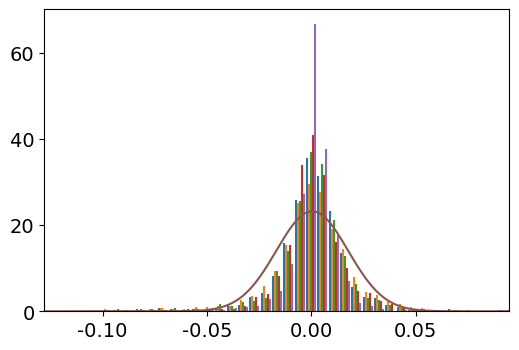

您选取的指数年化波动率为： 0.26874670892951974
您选取的 消费风格指数 每日收益率为： 日期
2014-01-02    0.000000
2014-01-03   -0.009236
2014-01-06   -0.026402
2014-01-07    0.006148
2014-01-08    0.005643
                ...   
2021-01-25    0.018888
2021-01-26   -0.021560
2021-01-27   -0.009178
2021-01-28   -0.020277
2021-01-29   -0.000754
Name: 消费风格指数, Length: 1727, dtype: float64
您选取的 消费风格指数 累积日收益率为： 日期
2014-01-02    1.000000
2014-01-03    0.990764
2014-01-06    0.964605
2014-01-07    0.970536
2014-01-08    0.976012
                ...   
2021-01-25    3.325237
2021-01-26    3.253544
2021-01-27    3.223683
2021-01-28    3.158315
2021-01-29    3.155935
Name: 消费风格指数, Length: 1727, dtype: float64
您选取的 消费风格指数 年化收益率为： 0.17630392681818918
您选取的 消费风格指数 夏普比率为： 0.6526497833707847
您选取的 消费风格指数 最大回撤为： 0.5039643829918391
您选取的 消费风格指数 calmar比率为： 0.349834100917097
您选取的 成长风格指数 每日收益率为： 日期
2014-01-02    0.000000
2014-01-03    0.003325
2014-01-06   -0.027272
2014-01-07    0.010446
2014-01-08    0.014938
                ...   
2021-01-2

/Users/chensn/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 31574 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chensn/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chensn/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chensn/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chensn/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chensn/opt/anaconda3/lib/python3.8/site-packages/matp

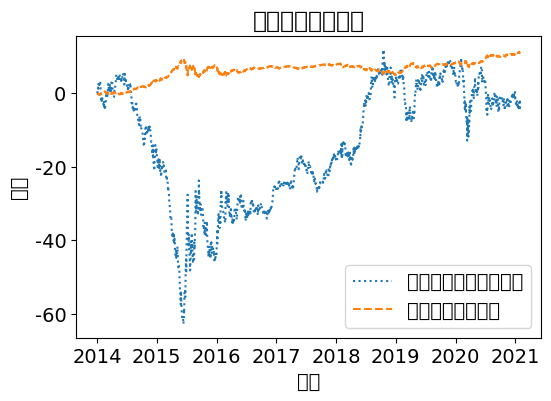

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 79139537378636.03
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 164285717925525.3
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 320159277265629.5
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 164858078559.83694
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7055811034480.529
            Iterations: 3
            Function evaluations: 28
      

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 94908550415089.97
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 297368191711336.75
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.7639683587297824e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1619798459623372.8
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 370471355537815.8
            Iterations: 3
            Function evaluations: 28
 

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.0577236692345387e+17
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.179470324041304e+16
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3.625107428292524e+18
            Iterations: 3
            Function evaluations: 32
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7.626537813249892e+17
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.0079174608418222e+16
            Iterations: 3
            Function e

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.6412542685502445e+17
            Iterations: 4
            Function evaluations: 52
            Gradient evaluations: 4
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 41021317549917.08
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2367573184.5517683
            Iterations: 4
            Function evaluations: 35
            Gradient evaluations: 4
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3103003717.936781
            Iterations: 6
            Function evaluations: 64
            Gradient evaluations: 6
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5753076987.881776
            Iterations: 4
            Function evaluations: 35


Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7714161265762.638
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 573725819185067.4
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3866523444261558.0
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8.673625845578767e+18
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3.5949694929281624e+16
            Iterations: 3
            Function evaluations:

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 64079441114951.55
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.0702114798471756e+21
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1248685982036892.0
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8.656552675927946e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6.509793686211238e+16
            Iterations: 1
            Function evaluatio

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 107737790290977.48
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.5852341061922412e+16
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 110752541643110.02
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 81704624343140.7
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.4110565456453162e+16
            Iterations: 4
            Function evaluations:

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 289494197316738.8
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5234902059108936.0
            Iterations: 3
            Function evaluations: 37
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6.897130389061323e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 343990904279.7056
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 163126621383896.2
            Iterations: 1
            Function evaluations: 6
   

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.6849149431676434e+18
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5.893582398687435e+19
            Iterations: 5
            Function evaluations: 70
            Gradient evaluations: 5
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9.63306946452349e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4.6178765965462266e+19
            Iterations: 4
            Function evaluations: 54
            Gradient evaluations: 4
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.9427430987058846e+23
            Iterations: 2
            Function ev

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 79139537378636.03
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 164285717925525.3
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 320159277265629.5
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 164858078559.83694
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7055811034480.529
            Iterations: 3
            Function evaluations: 28
      

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 571056715430332.0
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 139764707741015.55
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 130778800814495.8
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3.188969586160064e+20
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3786084871418975.0
            Iterations: 3
            Function evaluations: 28
 

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3.724733872672417e+16
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6874393036798664.0
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4.803721912732543e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.0577236692345387e+17
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.179470324041304e+16
            Iterations: 3
            Function evalua

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.6314984542030735e+20
            Iterations: 4
            Function evaluations: 44
            Gradient evaluations: 4
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 26972801103766.74
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1330410503086971.8
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2.7207445470433536e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1444715123463530.2
            Iterations: 3
            Function evaluations:

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 144079519101184.34
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 369013260053200.0
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 135543937740187.77
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6831809957664.893
            Iterations: 6
            Function evaluations: 73
            Gradient evaluations: 6
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7714161265762.638
            Iterations: 3
            Function evaluations: 28
      

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1084164182470.5055
            Iterations: 5
            Function evaluations: 63
            Gradient evaluations: 5
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1211985194728445.2
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 415986666875297.9
            Iterations: 6
            Function evaluations: 70
            Gradient evaluations: 6
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 60522466384127.36
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2.7140376826935494e+22
            Iterations: 4
            Function evaluations: 49


Optimization terminated successfully    (Exit mode 0)
            Current function value: 37363567857.4467
            Iterations: 11
            Function evaluations: 109
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 97808283228.1334
            Iterations: 10
            Function evaluations: 108
            Gradient evaluations: 10
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.3698806136642484e+16
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4.987134627227765e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.2487383814784854e+16
            Iterations: 1
            Function eva

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 48595986632060.59
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 70681156114484.06
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 33998931113053.47
            Iterations: 3
            Function evaluations: 29
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 991442287971490.6
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 148468915586134.7
            Iterations: 3
            Function evaluations: 28
        

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5.893582398687435e+19
            Iterations: 5
            Function evaluations: 70
            Gradient evaluations: 5
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9.63306946452349e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4.6178765965462266e+19
            Iterations: 4
            Function evaluations: 54
            Gradient evaluations: 4
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.9427430987058846e+23
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.2366019244437492e+28
            Iterations: 7
            Function e

In [75]:
if __name__ == '__main__':
    # 指定回测区间：
    startdate = '2013-12-31'
    enddate = '2021-1-29'
    
    #用户自己指定回测的调仓频率：'Q'代表季度，'M'代表月度，'Y'代表年度
    period = 'M'
    main()
    strategy_cycle_change(startdate,enddate,period)